<a href="https://colab.research.google.com/github/FelipeTriana/MachineLearning/blob/master/lab5_parte1_solved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Recuerda que una vez abierto, Da clic en "Copiar en Drive", de lo contrario no podras almacenar tu progreso**

Nota: no olvide ir ejecutando las celdas de código de arriba hacia abajo para que no tenga errores de importación de librerías o por falta de definición de variables.

In [1]:
#configuración del laboratorio
# Ejecuta esta celda!
%load_ext autoreload
%autoreload 2
#for local 
#import sys ; sys.path.append('../commons/utils/')
!wget https://raw.githubusercontent.com/jdariasl/ML_2020/master/Labs/commons/utils/general.py -O general.py --no-cache
from general import configure_lab5_1
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from tensorflow.keras.utils import plot_model
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) 
configure_lab5_1()
from lab5 import *
GRADER, dataset = part_1()

--2021-09-15 15:53:14--  https://raw.githubusercontent.com/jdariasl/ML_2020/master/Labs/commons/utils/general.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14633 (14K) [text/plain]
Saving to: ‘general.py’

general.py          100%[===================>]  14.29K  --.-KB/s    in 0.001s  

2021-09-15 15:53:14 (24.7 MB/s) - ‘general.py’ saved [14633/14633]

lab configuration started
installing libraries
downloading files
lab configured


# Laboratorio 5 - Parte 1. Redes recurrentes

En este  laboratorio entrenaremos una Red Neuronal Recurrente para la predicción de una serie de tiempo. 

Este problema corresponde a una configuración many-to-one. 

En este caso usaremos una serie de tiempo que corresponde al número de pasajeros internacionales por mes, desde el año 1949 hasta el año 1960. 

En la siguiente celda visualizamos los datos.

Debemos observar el aparente periodo que existe en nuestra variable. ¿cada cuantos meses parece repertirse el patrón de la serie?

tenemos dispnible nuestra base de datos en el pandas DF 'dataset' 



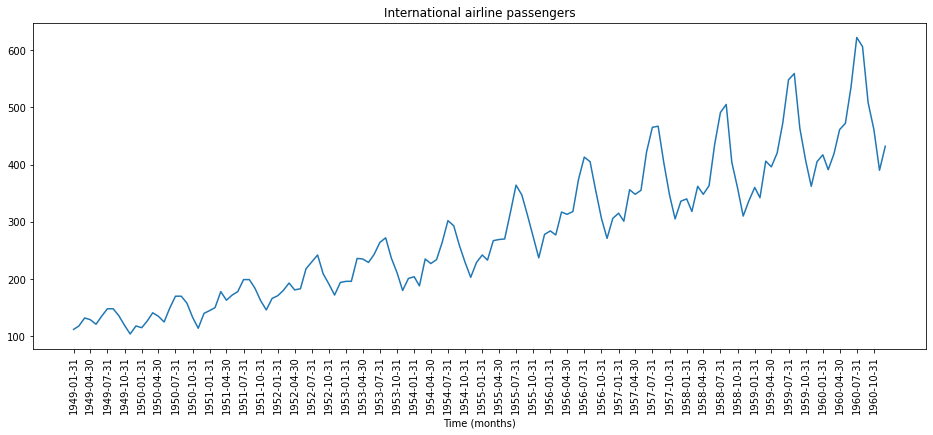

In [2]:
# creamos una variable para
# el tiempo
Time = pd.date_range(np.datetime64('1949-01'), np.datetime64('1961-01'), freq='M')

print("tenemos dispnible nuestra base de datos en el pandas DF 'dataset' \n")
fig, ax = plt.subplots(figsize = (16,6))
ax.plot(Time,dataset)
ax.set_title('International airline passengers')
ax.set_xlabel('Time (months)')
ax.set_xticks( pd.date_range(np.datetime64('1949-01'), np.datetime64('1961-01'), freq='3M'))
plt.xticks(rotation=90)
plt.show()

En nuestro primer ejercicio vamos a explorar, el patrón que observamos en la grafica anterior. Esto tambien nos puede decir que relación existe entre una muestra con las muestras inmediantamente pasadas. 

La libreria statsmodel [tiene una función que nos sirve para analizar esta relación](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html).


### Ejercicio 1 - Exploración del problema

Este plot realiza una operación cuyos detalles son explicados en mayor profundidad en [esta buena entrada de blog](https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/). Pero nuestro laboratorio lo que no interesa es entender:

1. El valor varia entre 1.0 y -1.0. 
2. Cuando el valor de la correlación es 1.0, corresponde el valor maximo indicando una relación positiva entre la variable y su correspondiente lag o retraso.
3. Cuando el valor de la correlación es -1.0, corresponde el valor mínimo indicando una relación negativa entre la variable y su correspondiente lag o retraso..
4. 0.0 indica que los valores no están relacionados.
5. el lag indica, el número de retrasos. Si el valor de la correlación en el lag  5 es igual 0.75, indica una relación positiva alta entre el quinto retraso anterior en la mayoria de muestras de nuestra variable de respuesta.

Ahora, grafiquemos la correlación para un maximo de 36 lags de nuestros datos. Esto significa que estamos analizando las relación de una muestras respecto a la 36 muestras pasdas.

Sabiendo que nuestro eje X representa los meses y nuestro eje y representan el numero de pasajeros. Al realizar el analisis de lags estamos determinando si el número de pasajeros de los meses pasados tiene influencia en el nuúmero de pasajeros en el mes acutal.

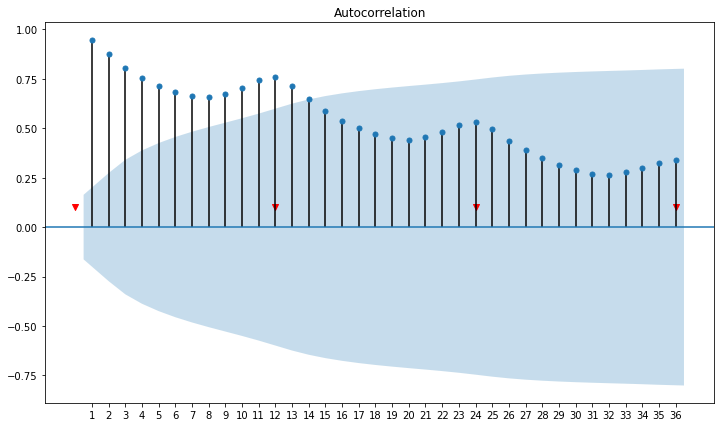

In [3]:
from statsmodels.graphics import tsaplots
fig, ax = plt.subplots(figsize = (12,7))
# Display the autocorrelation plot of your time series
fig = tsaplots.plot_acf(dataset.passengers, lags=range(1,37), ax = ax)
ax.set_xticks( range(1,37))
ax.scatter(range(0,37,12), 0.1*np.ones(4), c = 'r', marker = "v")
plt.show()

reforzando el entendimiento de lo anterior,en la grafica podemos ver lo siguiente:
1. cuando hay un lag = 5 (es decir evaluar que tan relacionadas estas las 5 muestras anteriores), tenemos una autocorrelación $\approx$ 0.75 
2. cuando hay un lag = 25 (es decir evaluar que tan relacionadas estas las 25 muestras anteriores), tenemos una autocorrelación $\approx$ 0.5
3. Presta atención al patrón que se resalta con las marcas rojas

Vamos observar estas relaciones viendo como los picos de correlación se relacionan con los patrones que vemos. Graficamos los valores de autocorrelación con la grafica de los valores reales.

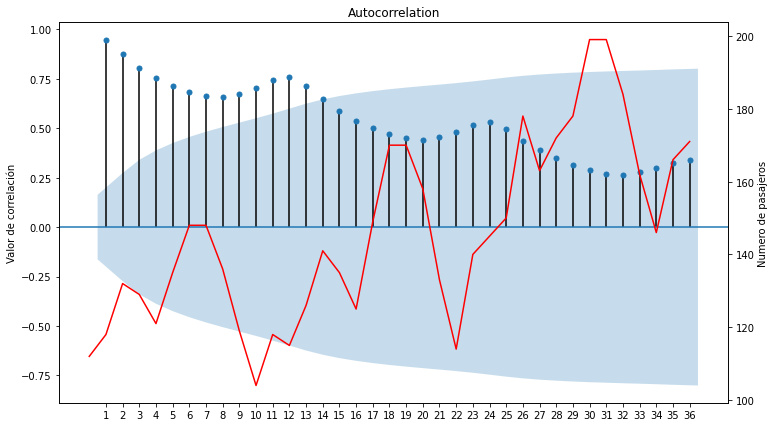

In [4]:
fig, ax = plt.subplots(figsize = (12,7))
# Display the autocorrelation plot of your time series
fig = tsaplots.plot_acf(dataset.passengers, lags=range(1,37), ax = ax)
ax.set_xticks( range(1,37))
ax.set_ylabel("Valor de correlación")
ax2 = ax.twinx()
ax2.set_ylabel("Numero de pasajeros")
ax2.plot(dataset[0:37], c = 'r')
plt.show()

Ahora bien, para poder aplicar nuestra RNN, debemos transformar nuestros datos. Observa la figura, para entender como debemos transformar los datos.

![rnn](https://raw.githubusercontent.com/jdariasl/ML_2020/master/Labs/commons/images/UDEA%20-%20RNN.jpg)

Sabiendo que nuestro anterior analisis de correlación nos indico como están  relacionadas las muestras pasadas y al entender que la preparación de datos consiste en usar las muestras pasadas para predicir la muestra siguiente. Responde la siguiente pregunta.

In [5]:
#@title Pregunta Abierta
#@markdown ¿Cual podria ser el numero maximo de muestras pasadas para transformar nuestros conjunto de datos?
respuesta_1 = "Seria el numero total de muestras menos una" #@param {type:"string"}

Finalmente, se propone la siguiente función para realizar la transformación

In [6]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    """funcion que crea dataset apto para RNN
    
    dataset: pandas dataframe con una sola columna
    look_back: numero de retrasos con los cuales queremos construir
        las caracteristicas
    """
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    
    return np.array(dataX), np.array(dataY).reshape(len(dataY), 1)

In [7]:
# observemos el funcionamiento
x_to_see, y_to_see =  create_dataset(dataset.values, 3)
display("primeras muestras de x", x_to_see[0:3])
display("primeras muestras de y", y_to_see[0:3])

'primeras muestras de x'

array([[112, 118, 132],
       [118, 132, 129],
       [132, 129, 121]])

'primeras muestras de y'

array([[129],
       [121],
       [135]])

### Ejercicio 2 - Experimentar con RNN

En este laboratorio vamos a explorar una libreria muy popular pero un poco más avanzada, para construir redes neuronales llamadas [TensorFlow](https://www.tensorflow.org/?hl=es-419).

En el siguiente ejercicio vamos a crear una función para construir una RNN usando la libreria mencionada.

In [8]:
# ejercicio de código 
# usar solo estos objetos
# importados
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN
import tensorflow as tf

def create_rnn_model(look_back, num_hidden_neurons):
    """funcion que crear modelo que usa mean_absolute_error
    como funcion de perdida
    RNN con base al número de lags y numero de neuronas

    
    parametros
    look_back (int): numero de retrasos a ejecutar
    num_hidden_neurons (int): numero neuronas en la capa oculta

    """
    # se inicializa el modelo
    # podemos asginar un nombre
    model = Sequential(name='rnn')
    # adicionar una capa RNN
    # reemplace los valores
    # asigna el nombre de rnn_layer
    rnn_layer = SimpleRNN(num_hidden_neurons, input_shape=(1, look_back), 
                          use_bias=True, name = 'rnn_layer') 
    # en tensorflow debemos adicionar la capa 
    # al modelo
    model.add(rnn_layer)
    # la red termina con una capa Densa de una salida
    model.add(Dense(1, name = "dense_layer"))
    # remplace la perdida por el parametro correcto
    model.compile(loss='mean_absolute_error', optimizer='adam')
    return(model)


In [9]:
GRADER.run_test("ejercicio1", create_rnn_model)

TEST EXITOSO!


'1 retraso, 2 neuronas ocultas'

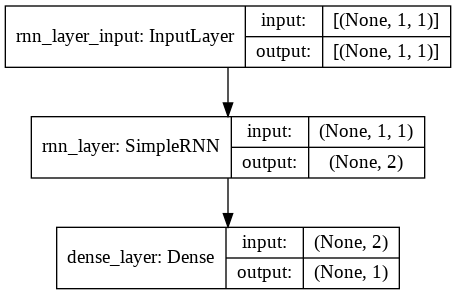

'4 retraso, 1 neuronas ocultas'

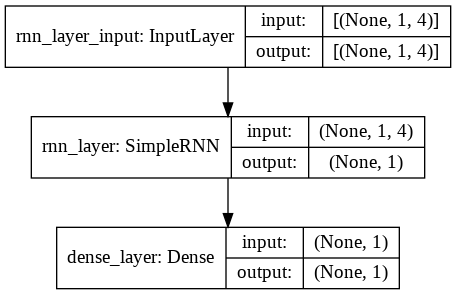

In [10]:
# observa la diferencias de los modelos al
# cambiar los parametros
# observe los inputs y output
# Los None hacer referencia al numero de muestras de los conjuntos
# de datos
display("1 retraso, 2 neuronas ocultas", plot_model(
    create_rnn_model(look_back = 1, num_hidden_neurons = 2), 
    show_shapes=True))

display("4 retraso, 1 neuronas ocultas", plot_model(
    create_rnn_model(look_back = 4,num_hidden_neurons = 1), 
    show_shapes=True))

Con nuestra funcion que crea modelos, vamos experimentar variando los dos parametros:

- número de retrasos
- número de neuronas en la capa oculta

Otras condiciones: 
- Vamos a dejar fijo el # de epocas 50.
- Usaremos la metrica Error absoluto. Recordar que solo usamos la implementaciones de [sklearn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)
- En la celda de codigo se propone la implementacion para cambiar las dimensiones de nuestras matrices. Este cambio es requerimiento de Tensorflow.


In [11]:
def datas_as_tensorflow(trainX, testX):
  # adaptar para compatibilidad con tensorflow
  # la libreria necesita tener los cojuntos de datos de la manera
  # (# muestras, 1, # de caraceristicas)
  trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
  testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
  return(trainX, testX)
  return(tf.convert_to_tensor(trainX), tf.convert_to_tensor(testX))


#ejercicio de código
def experimentar_rnn(data, look_backs, hidden_neurons):
    """funcion que realiza experimentos para evaluar una RNN de elman usando
        el error absoluto medio como medida de error
    
    data: pd.Dataframe, dataset a usar
    look_back: List[int], lista con los numero de retrasos a evaluar
    hidden_neurons: List[int], list con el numero de neuronas en la capa oculta
    retorna: pd.Dataframe con las siguientes columnas:
        - lags
        - neuronas por capas
        - error de entrenamiento
        - error de prueba
    """
    # Normalizar
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(data)
    # realizar el split
    train_size = int(len(dataset) * 0.7)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    resultados = pd.DataFrame()
    idx = 0
    for num_hidden_neurons in hidden_neurons:
        for look_back in look_backs:
            # aplicar la transformacion
            trainX, trainY = create_dataset(train, look_back)
            testX, testY = create_dataset(test, look_back)
            trainX, testX = datas_as_tensorflow(trainX, testX)
            # creemos el modelo
            model = create_rnn_model(look_back, num_hidden_neurons)
            # entrenemos el modelo
            model.fit(x = trainX, y = trainY, epochs=50,  verbose = 0)
            # predecimos en los conjuntos
            trainYPred  = model.predict(trainX)
            testYPred = model.predict(testX)
            errorPrueba = mean_absolute_error(testYPred,testY)
            errorEntrenamiento = mean_absolute_error(trainYPred,trainY)
            resultados.loc[idx,'lags'] = look_back
            resultados.loc[idx,'neuronas por capa'] = num_hidden_neurons
            resultados.loc[idx,'error de entrenamiento'] = errorEntrenamiento
            resultados.loc[idx,'error de prueba'] = errorPrueba
            idx+=1
            print("termina para", look_back, num_hidden_neurons)
    
    return (resultados)

In [12]:
GRADER.run_test("ejercicio2", experimentar_rnn)

termina para 1 5
termina para 2 5
termina para 1 7
termina para 2 7
TEST EXITOSO!


Ahora vamos a ver los resultados del experimentos:

1. variando los lags dejando las neuronas por capa fijas
2. variando las neuronas y dejando los retrasos fijos

experimente con diferentes configuraciones. Por la inicialización aleatorias los resultados pueden cambiar. Preste a los patrones que se van presentando y no a los valores exactos.

termina para 3 15
termina para 9 15
termina para 12 15
termina para 24 15
termina para 30 15
termina para 36 15


Text(0.5, 0.98, 'efecto del # retrasos')

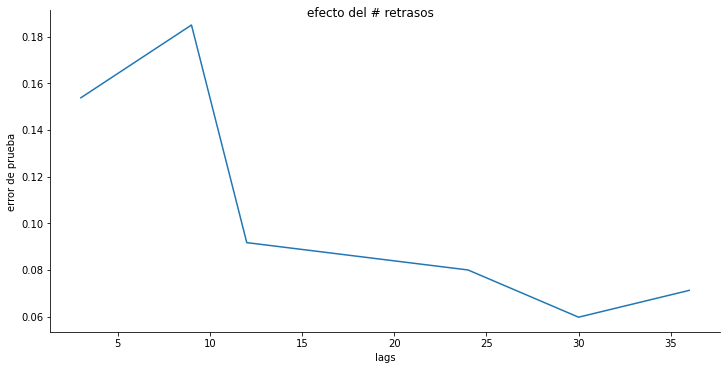

In [13]:
# observa el comportamiento de los lags
import seaborn as sns
resultadosRNN = experimentar_rnn(dataset, look_backs = [3,9,12,24,30,36], hidden_neurons=[15])
# plot
ax1  = sns.relplot(data= resultadosRNN, x= 'lags', y = 'error de prueba', kind = 'line', aspect = 2)
ax1.fig.suptitle('efecto del # retrasos')

termina para 9 5
termina para 9 15
termina para 9 30
termina para 9 60


Text(0.5, 0.98, 'efecto del # neuronas')

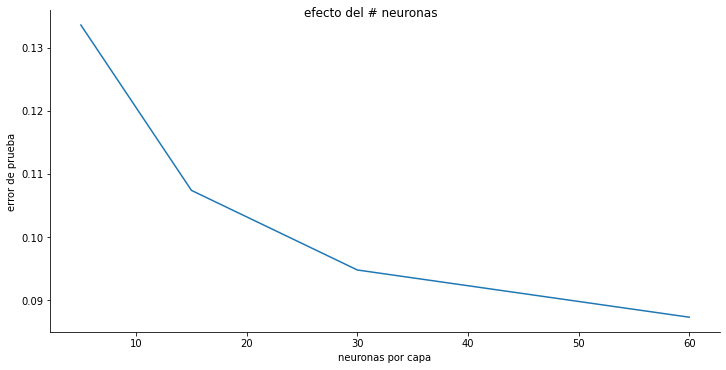

In [14]:
resultadosRNN = experimentar_rnn(dataset, look_backs = [9], hidden_neurons=[5,15,30,60])
ax2  = sns.relplot(data= resultadosRNN, x= 'neuronas por capa', y = 'error de prueba', kind = 'line', aspect = 2)
ax2.fig.suptitle('efecto del # neuronas')

In [15]:
#@title Pregunta Abierta
#@markdown ¿Por qué seguir aumentando los tiempos de retardo no implica siempre una mejora en la predicción del modelo?
respuesta_2 = "\"Existe la posibilidad de que con una mayor cantidad de tiempos de retardo se vaya inyectando una mayor cantidad de ruido, el cual se terminara propagando hacia las nuevas predicciones.\"" #@param {type:"string"}

In [16]:
#@title Pregunta Abierta
#@markdown ¿Entre el número de retrasos y de neuronas, que parámetro tiene una mayor influencia en el error de prueba?
respuesta_3 = "El numero de neuronas tiene una mayor influencia POSITIVA  en el error de prueba, ya que a mayor numero de neuronas el error suele disminuir significativamente en la mayor\xEDa de los casos, por otro lado, el numero de retrasos presenta grandes fluctuaciones que pueden ser un problema ya que el  error puede bajar mucho o subir mucho, aqu\xED no presenciamos una relaci\xF3n tan directa entre dicho parametro y el error de prueba. " #@param {type:"string"}

### Ejercicio 3 - Comparación con MLP

En este ejercicio vamos a realizar el mismo ejercicio, pero con un MLP. Con esto vamos a comparar los resultados obtenidos con la RNN.

Para ellos vamos a :
1. variar los retrasos, que corresponden a las neuronas en la capa de entrada
2. vamos a dejar solo una capa oculta y vamos a variar el número de neuronas en esta capa
3. el número de epocas también va ser de 50
4. el valor por defecto sera usado para el resto de parámetros
5. utilizar como medida de error el error absoluto medio.  [recordar usar la implementación del modulo de metricas de sklearn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)

In [17]:
#@title Pregunta Abierta
#@markdown ¿explique la principal diferencia entre un MLP y una red recurrente? justificar usando usando como contexto el problema que estamos resolviendo.
respuesta_4 = "En este problema las observaciones a la entrada son dependientes una de la otra, osea, las predicciones a futuro deben tomar informacion del pasado. En ese orden de ideas, una RNN es ideal para resolver problemas de este tipo pues su principal diferencia con una MLP es que en una RNN se agregan elementos de memoria a la arquitectura de la red, esa diferencia hace a las RNN idoneas para manejar problemas como este donde las observaciones a la entrada presentan dependencia." #@param {type:"string"}

In [18]:
#ejercicio de código
def experimentar_MLP(data, look_backs, hidden_neurons):
    """funcion que realiza experimentos para evaluar una MLPusando
        MAPE como medida de error                                    PIDE MAPE PERO SI LA IMPLEMENTAMOS LANZA UN ERROR, SOLO FUNCIONA CON MAE...
    
    data: pd.Dataframe, dataset a usar
    look_back: List[int], lista con los numero de retrasos a evaluar
    hidden_neurons: List[int], list con el numero de neuronas en la capa oculta
    retorna: pd.Dataframe con las siguientes columnas:
        - lags
        - neuronas por capas
        - error de prueba
        - tiempo de entrenamiento
    """
    # we need to normalize the dataset before
    #
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(data)
    # split into train and test sets
    train_size = int(len(dataset) * 0.7)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    resultados = pd.DataFrame()
    idx = 0
    for num_hidden_neurons in hidden_neurons:
        for look_back in look_backs:
            # reshape into X=t-look_back+1:t and Y=t+1
            trainX, trainY = create_dataset(train, look_back)
            testX, testY = create_dataset(test, look_back)          
            # define el MLP para Regresion pasando los parametros adecuados
            # pasar random_state = 10 para lograr resultados reproducibles
            net =  MLPRegressor(hidden_layer_sizes= (num_hidden_neurons,1), max_iter = 50, random_state = 10) 
            # Entrenar la red con los datos de entrenamiento
            net.fit(trainX, trainY)
            # Evaluar la red con los datos de entrenamiento y test
            trainYPred = net.predict(trainX)
            testYPred = net.predict(testX)
            # Calculo de error
            errorPrueba = mean_absolute_error(testY, testYPred)                         #MAPE lanza un error.....
            errorEntrenamiento = mean_absolute_error(trainY, trainYPred)                #MAPE lanza un error.....
            resultados.loc[idx,'lags'] = look_back
            resultados.loc[idx,'neuronas por capa'] = num_hidden_neurons
            resultados.loc[idx,'error de entrenamiento'] = errorEntrenamiento
            resultados.loc[idx,'error de prueba'] = errorPrueba
            idx+=1
    
    return (resultados)

In [19]:
GRADER.run_test("ejercicio3", experimentar_MLP)

TEST EXITOSO!


In [20]:
resultadosMLP = experimentar_MLP(dataset, look_backs = [3,9,12,24,30,36], hidden_neurons=[10,20,30])

In [21]:
# para ver los resultados
# en esta instruccion se va resaltar el mejor
# error
resultadosMLP.style.highlight_min(color = 'green', axis = 0, subset = ['error de prueba'])

,lags,neuronas por capa,error de entrenamiento,error de prueba
0,3.000000,10.000000,0.540504,0.409180
1,9.000000,10.000000,0.318562,0.129148
2,12.000000,10.000000,0.109357,0.422738
3,24.000000,10.000000,0.363810,0.799090
4,30.000000,10.000000,1.485777,1.886101
5,36.000000,10.000000,0.070353,0.448618
6,3.000000,20.000000,1.021789,1.457737
7,9.000000,20.000000,0.331699,0.728117
8,12.000000,20.000000,0.607844,0.205132
9,24.000000,20.000000,0.873160,0.437880


### Ejercicio 4 - Comparación con LSTM

En nuestro ultimo ejercicio, vamos a comparar los resultados obtenidos hasta ahora con una LSTM. Para ellos vamos a usar volver a usar [Tensorflow](https://www.tensorflow.org/?hl=es-419).



In [22]:
#@title Pregunta Abierta
#@markdown ¿por qué una red LSTM puede ser más adecuada para resolver este problema? justifique
respuesta_5 = "En especifico, la red LSTM esta disenada para tratar con datos a largo plazo y este puede aprovechar de mejor manera un historico de tiempos para entregar los mejores resultados." #@param {type:"string"}

Aca creamos el modelo LSTM usando tensorflow:

In [23]:
from tensorflow.keras.layers import LSTM

def create_lstm_model(look_back, num_hidden_neurons):
    """funcion que crear modelo LSTM con base al número de lags y numero de neuronas"""
    model = Sequential()
    model.add(LSTM(num_hidden_neurons, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

Vamos aseguranos de completar el código para lograr:
1. Epocas = 50
2. Pasar los parametros el la función `create_tf_model`
3. utilizar como medida de error el error absoluto medio.  [recordar usar la implementación del modulo de metricas de sklearn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)

In [24]:
#ejercicio de código
import tensorflow as tf
def experimentar_LSTM(data, look_backs, hidden_neurons):
    """funcion que realiza experimentos para evaluar una LSTM usando
        MAE Error Absoluto medio
    
    data: pd.Dataframe, dataset a usar
    look_back: List[int], lista con los numero de retrasos a evaluar
    hidden_neurons: List[int], list con el numero de neuronas en la capa oculta
    retorna: pd.Dataframe con las siguientes columnas:
        - lags
        - neuronas por capas
        - error de entrenamiento
        - error de prueba
    """
    # we need to normalize the dataset before
    #
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(data)
    # split into train and test sets
    train_size = int(len(dataset) * 0.7)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    resultados = pd.DataFrame()
    idx = 0
    for num_hidden_neurons in hidden_neurons:
        for look_back in look_backs:
            # reshape into X=t-look_back+1:t and Y=t+1
            trainX, trainY = create_dataset(train, look_back)
            testX, testY = create_dataset(test, look_back)
            # adaptar para compatibilidad con tensorflow
            trainX, testX = datas_as_tensorflow(trainX, testX)
            # llama la función definida anteriormente
            model = create_lstm_model(look_back, num_hidden_neurons)
            # pasa el las epocas requeridas
            model.fit(trainX, trainY, epochs=50,  verbose=0)
            # Evaluar la red con los datos de test y entrenamiento 
            trainYPred = model.predict(trainX)
            testYPred = model.predict(testX)
            # Calculo de error
            errorTrain = mean_absolute_error(trainY, trainYPred)
            errorTest = mean_absolute_error(testY, testYPred)
            resultados.loc[idx,'lags'] = look_back
            resultados.loc[idx,'neuronas por capa'] = num_hidden_neurons 
            resultados.loc[idx,'error de entrenamiento'] = errorTrain
            resultados.loc[idx,'error de prueba'] = errorTest
            idx+=1
            print("termina para", look_back, num_hidden_neurons)
    
    return (resultados)

In [25]:
# ignorar los prints!
GRADER.run_test("ejercicio4", experimentar_LSTM)

termina para 1 5
termina para 2 5
TEST EXITOSO!


In [26]:
# demora algunos minutos!
resultadosLSTM = experimentar_LSTM(dataset, [3,9,12,24,30,36], hidden_neurons=[5,10,15])

termina para 3 5
termina para 9 5
termina para 12 5
termina para 24 5
termina para 30 5
termina para 36 5
termina para 3 10
termina para 9 10
termina para 12 10
termina para 24 10
termina para 30 10
termina para 36 10
termina para 3 15
termina para 9 15
termina para 12 15
termina para 24 15
termina para 30 15
termina para 36 15


In [27]:
# para ver los resultados
# en esta instruccion se va resaltar el mejor
# error y tiempo de entrenamiento
resultadosLSTM.style.highlight_min(color = 'green', axis = 0, subset = ['error de prueba'])

,lags,neuronas por capa,error de entrenamiento,error de prueba
0,3.000000,5.000000,0.073718,0.206156
1,9.000000,5.000000,0.077357,0.243588
2,12.000000,5.000000,0.050036,0.112157
3,24.000000,5.000000,0.050823,0.145478
4,30.000000,5.000000,0.054936,0.126029
5,36.000000,5.000000,0.043883,0.096606
6,3.000000,10.000000,0.073637,0.184926
7,9.000000,10.000000,0.051273,0.111059
8,12.000000,10.000000,0.053612,0.115019
9,24.000000,10.000000,0.041177,0.122113


In [28]:
# compremos nuevamente con RNN simple
resultadosRNN = experimentar_rnn(dataset, look_backs = [3,9,12,24,30,36], hidden_neurons=[5,10,15])

termina para 3 5
termina para 9 5
termina para 12 5
termina para 24 5
termina para 30 5
termina para 36 5
termina para 3 10
termina para 9 10
termina para 12 10
termina para 24 10
termina para 30 10
termina para 36 10
termina para 3 15
termina para 9 15
termina para 12 15
termina para 24 15
termina para 30 15
termina para 36 15


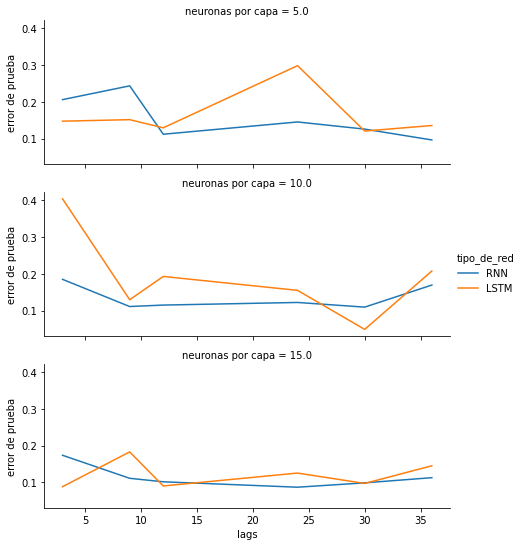

In [29]:
# observa el comportamiento de los lags y comparar con elman
import seaborn as sns
resultadosRNN['tipo_de_red'] = 'LSTM'
resultadosLSTM['tipo_de_red'] = 'RNN'
lstm_vs_elman = pd.concat([resultadosLSTM, resultadosRNN], axis= 0 , ignore_index = True)
sns.relplot(data= lstm_vs_elman, x= 'lags', y = 'error de prueba', kind = 'line', hue = 'tipo_de_red',  height = 2.5 , aspect = 2.5, row = 'neuronas por capa')

In [30]:
GRADER.check_tests()

Todo se ve ok. Asegurate de responder las preguntas abiertas y envia le archivo al formulario ¡buen trabajo!


In [31]:
#@title Integrantes
codigo_integrante_1 ='1035439685' #@param {type:"string"}
codigo_integrante_2 = '1020485954'  #@param {type:"string"}

----
esta linea de codigo va fallar, es de uso exclusivo de los profesores


In [32]:
GRADER.grade()

uso del docente
